# Prep demand and predictors data

In [30]:
import xarray as xr
import pandas as pd
import numpy as np
import glob

from workalendar.registry import registry

In [2]:
def get_calendar(market, subregion):
    """
    Get calendar for subregion, using electricity market names
    """
    if market == "NEM":
        if subregion == "NEM": # If entire market, use only national holidays
            return registry.get("AU")()
        region = "AU"
    else:
        raise ValueError("Incorrect market specified")
    return registry.get_subregions(region)[region + "-" + subregion]()

def rm_weekend(da, drop=False):
    """
    Set weekend days to NaN
    """
    return da.where(da.time.dt.dayofweek < 5, drop=drop)

def select_workday(da, calendar, drop=False):
    """
    Remove weekends and public holidays
    """
    is_workday = [calendar.is_working_day(pd.to_datetime(i)) for i in da["time"].values]
    da = da.assign_coords({"is_workday": ("time", is_workday)})
    return da.where(da.is_workday == True, drop=drop)

def rm_xmas(da):
    """
    Set 21/12 through 06/01 to NaN
    """
    da_ = da.where(
        da.where(
            (da.time.dt.month == 12) & 
            (da.time.dt.day > 20)
        ).isnull()
    )
    da_ = da_.where(
        da_.where(
            (da_.time.dt.month == 1) & 
            (da_.time.dt.day < 7)
        ).isnull()
    )
    return da_

def rm_month(da, month):
    """
    Set a particular month to NaN
    """
    if month not in range(1, 13):
        raise ValueError("Month must be integer between 1 and 12")
    return da.where(da.time.dt.month != month)

def remove_time(da, weekend=False, xmas=False, month=0, calendar=None):
    """
    Returns da with weekends, xmas, or a month removed if desired
    """
    if weekend:
        # da = rm_weekend(da)
        da = select_workday(da, calendar)
    if xmas:
        da = rm_xmas(da)
    if month > 0:
        da = rm_month(da, month)
        
    return da.dropna("time")

In [27]:
def get_predictor_files(region, mask, detrended=True):
    """
    Return a list of desired predictor filenames/
    
    region: str, name of region
    mask: str, name of mask
    """
    path = "/g/data/w42/dr6273/work/projects/Aus_energy/"
    ext = region + "_" + mask
    if detrended:
        ext = ext + "_detrended"
    return glob.glob(path + "demand_predictors/*" + ext + ".nc")

In [36]:
def to_dataframe(target_da, predictors_ds, region):
    """
    Convert xarray data to pandas dataframe.
    """
    # Predictors to array
    predictors_arr = predictors_ds.sel(region=region, time=target_da["time"]).to_array("variable")
    
    # Data array of target and predictors
    da = xr.concat([
        predictors_arr,
        target_da.sel(region=region).expand_dims({"variable": ["demand"]})
    ],
        dim="variable"
    )
    
    # Dataframe
    df = pd.DataFrame(
        da.transpose(),
        columns=da["variable"],
        index=target_da["time"]
    )
    
    return df

def add_time_column(df, method, calendar=None):
    """
    Add a time column to df.
    
    df: dataframe to add to
    method: str indicating which method to use. Currently 'is_weekend',
            'month_sin', 'month_cos', 'month_int', 'season_int'
    calendar: None, or calendar from registry
    """
    if method == "is_weekend":
        # Bool for weekend day or weekday
        # new_col = (df.index.weekday > 4).astype("int16")
        
        # Bool for weekend/public holiday or working day
        is_workday = [calendar.is_working_day(pd.to_datetime(i)) for i in df.index.values]
        is_workday = [0 if i else 1 for i in is_workday] # Swap 1s and 0s
        new_col = np.array(is_workday).astype("int16")
    elif method == "is_transition":
        new_col = df.index.month.isin([3, 4, 5, 9, 10, 11])
    elif method == "month_sin":
        new_col = np.sin((df.index.month - 1) * (2. * np.pi / 12))
    elif method == "month_cos":
        new_col = np.cos((df.index.month - 1) * (2. * np.pi / 12))
    elif method == "month_int":
        new_col = df.index.month
    elif method == "season_int":
        new_col = df.index.month % 12 // 3 + 1
    else:
        raise ValueError("Incorrect 'method'.")
    
    df[method] = new_col
    return df

### Set global variables

In [3]:
PATH = "/g/data/w42/dr6273/work/projects/Aus_energy/"

In [4]:
DEMAND_FILE = "daily_demand_2010-2020_stl.nc"

In [5]:
MARKET = "NEM" # "NEM" or "EU"

In [21]:
REGION = "NSW"

In [7]:
REMOVE_WEEKEND = True

In [8]:
REMOVE_XMAS = True

In [9]:
REMOVE_MONTH = 0 # integer: [1, 12]

In [10]:
MASK_NAME = "pop_dens_mask"

In [11]:
TIME_COLUMNS = []

In [12]:
FIRST_TRAIN_YEAR = 2010
LAST_TRAIN_YEAR = 2016

In [13]:
FIRST_TEST_YEAR = 2017
LAST_TEST_YEAR = 2019

In [14]:
# N_FEATURES = "parsimonious"

In [38]:
T_ONLY = False

In [16]:
CALENDAR = get_calendar(MARKET, REGION)

### Prepare demand data

In [22]:
dem_da = xr.open_dataset(PATH + "data/energy_demand/" + DEMAND_FILE)["demand_stl"]

In [23]:
dem_da = remove_time(dem_da, REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, calendar=CALENDAR)

In [24]:
dem_da = dem_da.sel(region=REGION).expand_dims({"region": [REGION]})

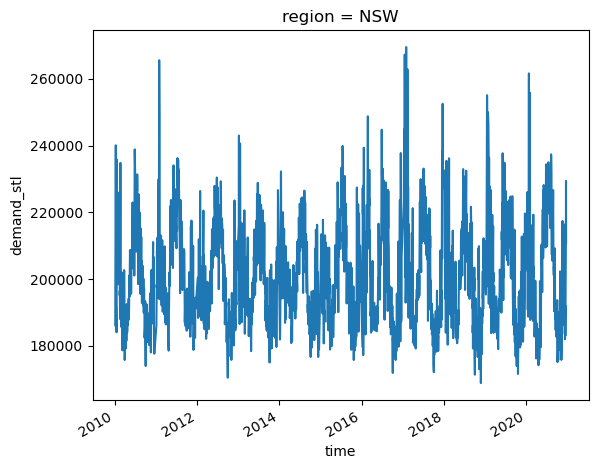

In [25]:
dem_da.plot()

In [26]:
dem_da

<xarray.DataArray 'demand_stl' (region: 1, time: 2694)>
array([[186114.71026898, 191585.53391295, 215503.16750874, ...,
        212154.92781663, 229400.0483697 , 210921.00195785]])
Coordinates:
  * region      (region) object 'NSW'
  * time        (time) datetime64[ns] 2010-01-07 2010-01-08 ... 2020-12-18
    is_workday  (time) bool True True True True True ... True True True True

### Prepare predictors

In [31]:
files = get_predictor_files(MARKET, MASK_NAME)
files

['/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/hdd_18_rollmean4_era5_daily_1959-2022_NEM_pop_dens_mask_detrended.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/2t_rollmean3_era5_daily_1959-2022_NEM_pop_dens_mask_detrended.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/rh_era5_daily_1959-2022_NEM_pop_dens_mask_detrended.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/2t_rollmean4_era5_daily_1959-2022_NEM_pop_dens_mask_detrended.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/2tmin_era5_daily_1959-2022_NEM_pop_dens_mask_detrended.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/cdd_24_era5_daily_1959-2022_NEM_pop_dens_mask_detrended.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/10w_era5_daily_1959-2022_NEM_pop_dens_mask_detrended.nc',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/hdd_18_rollmean3_era5_daily_1959-2022_NEM_pop_d

In [32]:
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override")

In [33]:
pred_ds = pred_ds.sel(region=REGION).expand_dims({"region": [REGION]}).compute()

In [34]:
pred_ds = remove_time(pred_ds, REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, calendar=CALENDAR)

In [35]:
pred_ds

<xarray.Dataset>
Dimensions:     (region: 1, time: 15664)
Coordinates:
  * region      (region) object 'NSW'
  * time        (time) datetime64[ns] 1959-01-07 1959-01-08 ... 2022-12-20
    is_workday  (time) bool True True True True True ... True True True True
Data variables:
    hdd         (region, time) float64 0.1241 0.1078 0.1735 ... 1.839 1.718
    t2m3        (region, time) float64 295.0 294.7 293.6 ... 289.0 289.0 289.2
    rh          (region, time) float64 72.8 72.55 70.37 ... 60.05 59.18 62.63
    t2m4        (region, time) float64 294.5 294.6 294.2 ... 289.4 289.0 289.2
    t2min       (region, time) float64 292.0 290.4 289.6 ... 285.2 285.3 285.1
    cdd         (region, time) float64 0.09991 0.04624 ... 0.008276 0.01916
    w10         (region, time) float64 3.082 3.716 3.697 ... 4.696 4.42 2.947
    q           (region, time) float64 11.54 10.83 10.1 ... 6.724 6.54 7.254
    mtpr        (region, time) float64 1.306e-05 2.006e-05 ... 5.691e-06
    t2m         (region, time) float64 294.4 293.5 292.8 ... 288.9 288.9 289.6
    msdwswrf    (region, time) float64 200.4 189.9 209.5 ... 276.0 329.1 308.2
    t2max       (region, time) float64 297.3 296.4 295.6 ... 292.3 293.0 293.3

## Prepare dataframe for machine learning

In [39]:
region_dfs = {}
for region in dem_da.region.values:
    df = to_dataframe(dem_da, pred_ds, region)
    
    for t in TIME_COLUMNS:
        df = add_time_column(df, t, calendar=CALENDAR)
        
    if T_ONLY:
        new_cols = np.append(np.append("demand", TIME_COLUMNS), ["mtpr", "w10", "msdwswrf", "rh", "q", "t2m"])
    else:
        new_cols = np.append(np.append("demand", TIME_COLUMNS), df.columns[:-(len(TIME_COLUMNS) + 1)])
    df = df[new_cols]
    
    region_dfs[region] = df

In [40]:
region_dfs[region].head()

,demand,hdd,t2m3,rh,t2m4,t2min,cdd,w10,q,mtpr,t2m,msdwswrf,t2max
2010-01-07,186114.710269,0.007732,295.462565,71.384486,295.037306,292.153904,0.125819,2.670003,11.394804,1.220994e-05,294.489710,220.577600,297.420743
2010-01-08,191585.533913,0.004078,295.279558,70.648160,295.584381,291.511986,0.337830,2.344185,12.254509,5.714371e-06,295.949524,283.436342,299.690657
2010-01-11,215503.167509,0.000025,298.449612,70.372027,297.824657,293.717450,1.091115,3.247642,13.343314,3.184828e-07,297.628731,308.849279,301.403077
2010-01-12,240091.354585,0.000000,298.543470,61.566510,298.945980,294.918745,3.597900,2.469718,14.070295,2.931551e-06,300.434798,338.232604,306.595553
2010-01-13,204167.493766,0.004881,297.656083,73.892375,297.633769,291.801478,0.217198,4.408566,12.213959,2.063133e-05,294.904393,284.872303,301.015210


In [41]:
region_dfs[region].to_csv(
    region + "_data.csv",
)

In [42]:
!pwd

/g/data/w42/dr6273/work
